In [1]:
import h5py
import pandas as pd
import glob
import numpy as np
from scipy.stats import gaussian_kde
import pymc as pm
from pylab import *
import aesara.tensor as at
import aesara.tensor.extra_ops as ate
import arviz as az

WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
cols = ['luminosity_distance', 'mass_1'] # Only taking directly observable values
n_runs = 100   # number of random plots to make
n_m = 100    # resolution of mass points to find max over
n_mc = 5     # number of points to fit for the MCMC
m_cut = 25   # M_sun

mass_array = np.zeros((n_runs, n_mc))

In [3]:
def at_interp(x, xs, ys):
    '''Custom linear interpolator'''
    x  = at.as_tensor(x)
    xs = at.as_tensor(xs)
    ys = at.as_tensor(ys)

    n = xs.shape[0]
    
    ind = ate.searchsorted(xs, x)
    ind = at.where(ind >= n, n-1, ind)
    ind = at.where(ind < 0, 0, ind)
    r = (x - xs[ind-1])/(xs[ind]-xs[ind-1]) 
    return r*ys[ind] + (1-r)*ys[ind-1]

In [4]:
def Ez(z, Om, w):
    opz = 1 + z
    return at.sqrt(Om*opz*opz*opz + (1-Om)*opz**(3*(1+w)))

def dCs(zs, Om, w):
    dz = zs[1:] - zs[:-1]
    fz = 1/Ez(zs, Om, w)
    I = 0.5*dz*(fz[:-1] + fz[1:]) #trapazoidally integrating
    return at.concatenate([at.as_tensor([0.0]), at.cumsum(I)])

def dLs(zs, dCs):
    return dCs*(1+zs)

In [5]:
def make_model(ms_obs, sigma_ms_obs, dls, zmax=100):
    zinterp = expm1(linspace(log(1), log(1+zmax), 1024))

    with pm.Model() as model:
        w = pm.Normal('w', mu=-1, sigma=0.25) 
        #w = pm.Uniform('w', -1.5, -0.5, initval=-1)

#         Om = pm.Uniform('Om', 0, 1, initval=0.3) #should we fix this at 0.3 for now?
        Om = pm.Bound('Om', pm.Normal.dist(mu=0.3, sigma=0.15), lower=0, upper=1)

        h = pm.Lognormal('h', mu=log(0.7), sigma=0.2)
        Ode = pm.Deterministic('Ode', 1-Om)
        om = pm.Deterministic('om', Om*h*h)
        ode = pm.Deterministic('ode', Ode*h*h)

        dH= pm.Deterministic('dH', 2.99792/h)
        m0 = pm.Lognormal('m0', mu=log(35), sigma=0.5)

        dCinterp = dH*dCs(zinterp, Om, w)
        dLinterp = dLs(zinterp, dCinterp)
        
        zs = pm.Deterministic('zs', at_interp(dls, dLinterp, zinterp))

        pm.Normal('m_likelihood', mu=m0*(1+zs), sigma=sigma_ms_obs, observed=ms_obs)
    return model

In [6]:
for run in range(n_runs):
    df = False #janky method, alternative would be strongly appreciated

    for f in glob.glob('O3b-data/*mixed_cosmo.h5'):
        with h5py.File(f, 'r') as hf:
            post = np.array(hf['C01:Mixed/posterior_samples'])
            if np.median(post['mass_1']) < m_cut:
                continue
            data_array = np.random.choice(post, 1)
            if type(df) == bool: #janky method continued
                df = pd.DataFrame(data_array)[cols]
            else:
                if np.median(data_array['mass_1']) > m_cut:
                    df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
    
    arr = np.array([df['luminosity_distance'], df['mass_1']])
    kde = gaussian_kde(arr)


    dlmin = 0
    dlmax = max(df['luminosity_distance'])
    mmin = 0
    mmax = max(df['mass_1'])

    DL, M = np.mgrid[dlmin:dlmax:n_mc*1j, mmin:mmax:n_m*1j]
    positions = np.vstack([DL.ravel(), M.ravel()])
    K = np.reshape(kde(positions).T, DL.shape)

    d_ls = np.linspace(0, np.max(df['luminosity_distance'])/1000, n_mc)

    ms = np.linspace(0, np.max(df['mass_1']), n_m)

    for i, dl in enumerate(K):
        mass_array[run, i] = ms[np.argmax(dl)]


/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:

/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:

/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:

/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:

/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:

/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:

/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:

/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:

/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:

/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:

/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:

/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:

/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:

/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:

/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:

/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:

/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:

/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:

/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:

/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:

/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:

/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:

/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:

/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:

/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:

/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:

/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:

/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:

/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:

/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:

/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:

/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:

/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:

/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:

/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:

/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:

/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:

/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:

/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:

/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:

/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:

/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:

/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:

/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:

/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:

/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:

/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:

/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:

/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:

/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:

/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:

/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:

/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:

/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:

/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:

/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:

/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:

/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:

/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:

/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:

/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:

/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:

/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:

/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:

/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]
/tmp/ipykernel_109162/3798575233.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(data_array), ignore_index=True)[cols]


[0.         1.18601611 2.37203223 3.55804834 4.74406445]
[ 28.06249591  62.42251529  98.6063598  129.63189103 170.93369699]
[  8.13049112  20.36474752  56.55697195  86.63013818 128.61086819]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
/home/tanner/.local/lib/python3.10/site-packages/pymc/aesaraf.py:1005: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
/home/tanner/.local/lib/python3.10/site-packages/pymc/step_methods/hmc/quadpotential.py:611: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w, Om, h, m0]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
/home/tanner/.local/lib/python3.10/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


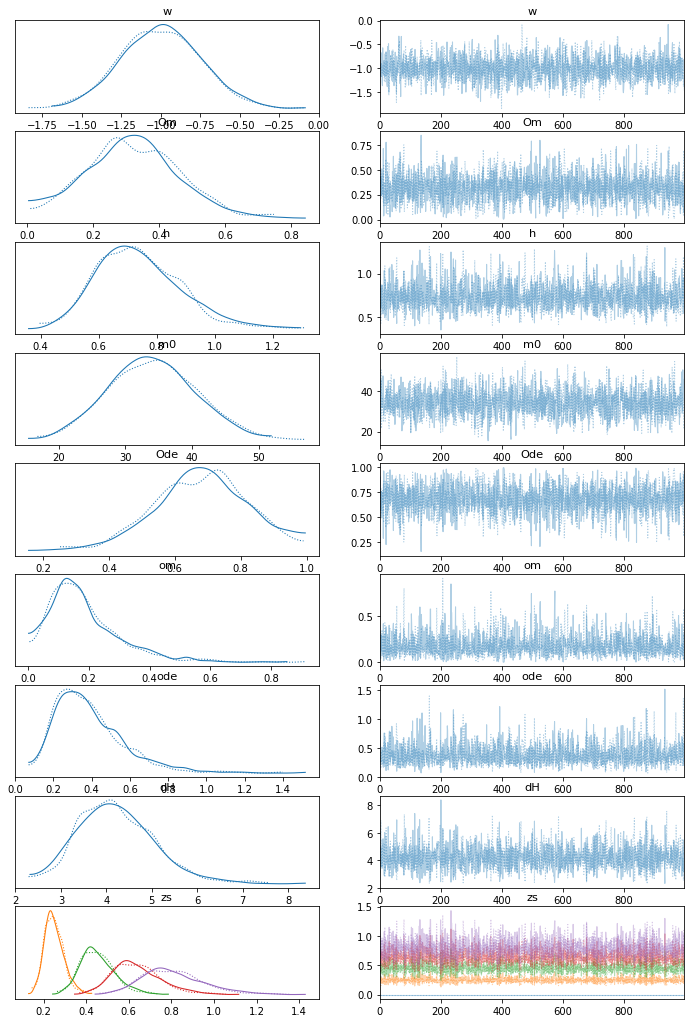

In [7]:
mu_m = np.mean(mass_array, axis=0)
sigma_m = np.std(mass_array, axis=0)
print(d_ls)
print(mu_m)
print(sigma_m)


with make_model(ms_obs=mu_m, sigma_ms_obs=sigma_m, dls=d_ls, zmax=100) as model:
    trace = pm.sample(init='jitter+adapt_full')
    az.plot_trace(trace)

In [8]:
df = trace.to_dataframe()

In [9]:
print(df[('posterior', 'h')].median())
print(df[('posterior', 'dH')].median())
print(df[('posterior', 'h')].std())


0.7245090128274725
4.137864371329056
0.14981515021480438


In [10]:
trace.to_netcdf("O3bcosmo.nc")

'O3bcosmo.nc'

# Now let's try adding O3a and 3b together?

In [14]:
d_ls = np.linspace(0, 50, n_mc)
for run in range(n_runs):
    df = False #janky method, alternative would be strongly appreciated

    for f in glob.glob('O3b-data/*mixed_cosmo.h5'):
        with h5py.File(f, 'r') as hf:
            post = np.array(hf['C01:Mixed/posterior_samples'])
            if (np.median(post['mass_1']) < m_cut) \
                and (np.median(post['luminosity_distance']) > 10000):
                continue
            data_array = np.random.choice(post, 1)
            if type(df) == bool: #janky method continued
                df = pd.DataFrame(data_array)[cols]
            else:
                if np.median(data_array['mass_1']) > m_cut:
                    df = pd.concat([df, pd.DataFrame(data_array)], ignore_index=True)[cols]

    for f in glob.glob('../LIGO-O3a-Posterior/all_posterior_samples/*comoving.h5'):
        with h5py.File(f, 'r') as hf:
            post = np.array(hf['PublicationSamples/posterior_samples'])
            if np.median(post['mass_1']) < m_cut:
                continue
            data_array = np.random.choice(post, 1)
            if type(df) == bool: #janky method continued
                df = pd.DataFrame(data_array)[cols]
            else:
                if np.median(data_array['mass_1']) > m_cut:
                    df = pd.concat([df, pd.DataFrame(data_array)], ignore_index=True)[cols]

    arr = np.array([df['luminosity_distance'], df['mass_1']])
    kde = gaussian_kde(arr)


    dlmin = 0
    dlmax = max(df['luminosity_distance'])
    mmin = 0
    mmax = max(df['mass_1'])

    DL, M = np.mgrid[dlmin:dlmax:n_mc*1j, mmin:mmax:n_m*1j]
    positions = np.vstack([DL.ravel(), M.ravel()])
    K = np.reshape(kde(positions).T, DL.shape)

#     d_ls = np.linspace(0, np.max(df['luminosity_distance'])/1000, n_mc)

    ms = np.linspace(0, np.max(df['mass_1']), n_m)

    for i, dl in enumerate(K):
        mass_array[run, i] = ms[np.argmax(dl)]



[ 28.33528846  60.04351376  88.97411703 123.04982456 173.95873017]
[  6.54501107  12.12645784  42.5465071   79.97460023 130.53411917]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/tanner/.local/lib/python3.10/site-packages/pymc/aesaraf.py:1005: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w, Om, h, m0]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
/home/tanner/.local/lib/python3.10/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


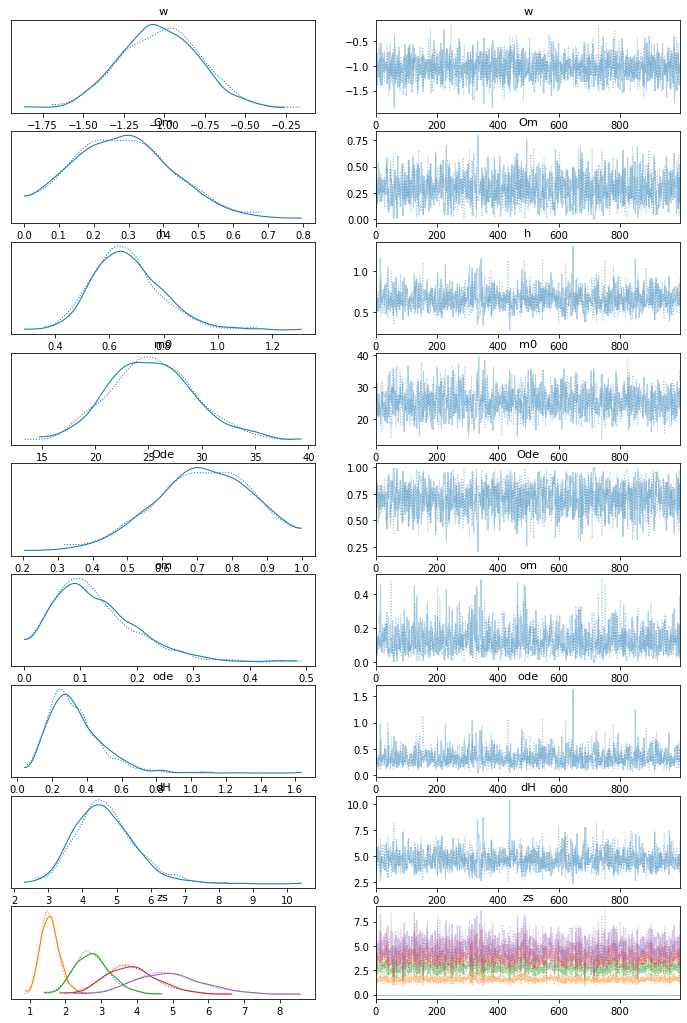

In [15]:
mu_m = np.mean(mass_array, axis=0)
sigma_m = np.std(mass_array, axis=0)
print(mu_m)
print(sigma_m)


with make_model(ms_obs=mu_m, sigma_ms_obs=sigma_m, dls=d_ls, zmax=100) as model:
    trace = pm.sample()
    az.plot_trace(trace)

In [16]:
df = trace.to_dataframe()
print(df[('posterior', 'h')].median())
print(df[('posterior', 'dH')].median())
print(df[('posterior', 'h')].std())


0.6522862911296026
4.59601872034442
0.12585157720622994


In [17]:
trace.to_netcdf("../O3a-bcosmo.nc")

'../O3a-bcosmo.nc'